In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import numpy as np
import torch
from src.utils_standardize import DataNormalizer
site_df = pd.read_csv('data/abcd_y_lt.csv').iloc[:,[0,2,7]]
testdata = pd.read_csv('data/test.csv')
testdata = testdata[testdata.columns[~testdata.columns.str.startswith("cbcl")]]
traindata = pd.read_csv('data/train.csv')
traindata = traindata[traindata.columns[~traindata.columns.str.startswith("cbcl")]]
lostcolumns= ["interview_date","site","src_subject_id","y_t", "y_{t+1}", "eventname","race_ethnicity","urban"]
site_df['interview_date'] = pd.to_datetime(site_df['interview_date'], errors = 'coerce')
traindata['interview_date'] = pd.to_datetime(traindata['interview_date'], errors = 'coerce')
testdata['interview_date'] = pd.to_datetime(testdata['interview_date'], errors = 'coerce')
site_df['site_id_l'] = site_df['site_id_l'].str[4:].astype(int)
subject_date_site_mapping = (
    site_df.groupby('src_subject_id')
    .apply(lambda x: dict(zip(x['interview_date'], x['site_id_l'])))
    .to_dict()
)
def get_site(row):
    subject_id = row['src_subject_id']
    interview_date = row['interview_date']
    return subject_date_site_mapping.get(subject_id, {}).get(interview_date, None)

df_urban = pd.read_csv("data/led_l_urban.csv")
traindata['site'] = traindata.apply(get_site, axis=1)
traindata.insert(1, 'site', traindata.pop('site'))
traindata = traindata.merge(
    df_urban[['src_subject_id', 'reshist_addr1_urban_area']],
    on='src_subject_id',
    how='left'  
)
traindata.insert(1, 'urban', traindata.pop('reshist_addr1_urban_area'))


testdata['site'] = traindata.apply(get_site, axis=1)
testdata.insert(1, 'site', testdata.pop('site'))  
testdata = testdata.merge(
    df_urban[['src_subject_id', 'reshist_addr1_urban_area']],
    on='src_subject_id',
    how='left' 
)
testdata.insert(1, 'urban', testdata.pop('reshist_addr1_urban_area'))  

testdata = testdata.apply(pd.to_numeric,errors='coerce')

traindata = traindata.apply(pd.to_numeric,errors='coerce')

data = pd.concat([traindata, testdata], axis=0, ignore_index=True)



if data.isnull().any().any():
    data = data.fillna(0)

data['white'] = (data['race_ethnicity'] == 1).astype(int)
data['black'] = (data['race_ethnicity'] == 2).astype(int)
data['hispano'] = (data['race_ethnicity'] == 3).astype(int)
data['asian'] = (data['race_ethnicity'] == 4).astype(int)
data['others'] = (data['race_ethnicity'] == 5).astype(int)



data_mapping = {
    site: group_df for site, group_df in data.groupby('site') if site != 22
}
maxx=0
people_num =[]
for i in data_mapping:
    people_num.append(len(data_mapping[i]))
    if len(data_mapping[i])>maxx:
        maxx=len(data_mapping[i])
        largest_site_index=i

largest_site_index = [16]


traindata = pd.concat(
[data_mapping[testiter] for testiter in data_mapping if testiter in largest_site_index], 
axis=0, 
ignore_index=True
)
data_train, hatdata = train_test_split(traindata, test_size=0.2, random_state=42)
data_test =testdata

X_train = data_train
feature_names = X_train.columns



top_vars = [x for x in X_train.columns if x not in lostcolumns]


y_train = data_train["y_{t+1}"]
input_dim = X_train.shape[1]
filtered_list = [num for num in range(1, 22) if num not in largest_site_index]


white_proportion = []
hispano_proportion = []
black_proportion = []
asian_proportion = []
other_proportion = []
for i in filtered_list:
    
    white_proportion.append(round((data_mapping[i]['race_ethnicity'] == 1).mean(),2))
    hispano_proportion.append((data_mapping[i]['race_ethnicity'] == 3).mean())
    black_proportion.append((data_mapping[i]['race_ethnicity'] == 2).mean())
    asian_proportion.append((data_mapping[i]['race_ethnicity'] == 4).mean())
    other_proportion.append((data_mapping[i]['race_ethnicity'] == 5).mean())


normalizer = DataNormalizer(exclude_columns=lostcolumns)

X_train = normalizer.fit_transform(X_train)
X_train = X_train[top_vars]
X_train = X_train.values

data = normalizer.transform(data)
hatdata = normalizer.transform(hatdata)
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

/var/folders/47/91sqyf453hs814g86jzgnwdh0000gn/T/ipykernel_544/1491377146.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: dict(zip(x['interview_date'], x['site_id_l'])))


In [3]:
import numpy as np
from src.models_logistic import (
    TraditionalLogisticRegression,
    RegularizedLogisticRegression,
    DROLogisticRegression,
    tune_model_with_optuna,
    evaluate_model_across_sites,
)

# 固定参数
fixed_params = {
    "learning_rate": 0.01,
    "num_epochs": 9000,
}

# Regularization 调 lambda
reg_param_ranges = {
    "lambda_val": {"type": "float", "low": 1e-5, "high": 1, "log": True},
}
reg_fixed_params = fixed_params.copy()

# DRO 调 kappa + wasserstein
dro_param_ranges = {
    "kappa": {"type": "float", "low": 1e-5, "high": 1, "log": True},
    "wasserstein": {"type": "float", "low": 5.0, "high": 60.0},  # 新增部分
}
dro_fixed_params = {**fixed_params, "kappacoef": 1.0}

# =======================
# 1. Traditional (固定训练)
# =======================
print("Training Logistic - Traditional (No tuning)")
trad_model = TraditionalLogisticRegression(
    input_dim=X_train.shape[1],
    num_classes=4,
    **fixed_params
)
trad_model.train(X_train, y_train)
trad_results = evaluate_model_across_sites(
    trad_model, top_vars, data=data, filtered_list=filtered_list, evaluate_race=False
)

# =======================
# 2. Regularization (调 lambda)
# =======================
print("Tuning Logistic - Regularization")
(reg_model, reg_results), reg_study = tune_model_with_optuna(
    RegularizedLogisticRegression,
    X_train,
    y_train,
    hatdata,
    top_vars,
    data,
    filtered_list,
    param_ranges=reg_param_ranges,
    fixed_params=reg_fixed_params,
    n_trials=150
)

# =======================
# 3. DRO (调 kappa + wasserstein)
# =======================
print("Tuning Logistic - DRO")
(dro_model, dro_results), dro_study = tune_model_with_optuna(
    DROLogisticRegression,
    X_train,
    y_train,
    hatdata,
    top_vars,
    data,
    filtered_list,
    param_ranges=dro_param_ranges,
    fixed_params=dro_fixed_params,
    n_trials=600
)

# =======================
# Summary
# =======================
print("================== Logistic Summary ==================")
print("Best Validation AUCs (on hatdata):")
print("Regularization:", reg_study.best_value)
print("DRO:", dro_study.best_value)

print("Mean AUC across sites:")
print("Traditional:", np.mean(trad_results["auc_all"]))
print("Regularization:", np.mean(reg_results["auc_all"]))
print("DRO:", np.mean(dro_results["auc_all"]))


Training Logistic - Traditional (No tuning)
Tuning Logistic - Regularization
[Final Results Summary]
Best Validation AUC: 0.8323097826086957
Best Parameters: {'lambda_val': 0.06282485833512257}
Average AUC across sites: 0.7754009204234418
Tuning Logistic - DRO
[Final Results Summary]
Best Validation AUC: 0.8387907608695653
Best Parameters: {'kappa': 0.6876138983171082, 'wasserstein': 25.21736044613385}
Average AUC across sites: 0.7815698662920428
================== Logistic Summary ==================
Best Validation AUCs (on hatdata):
Regularization: 0.8323097826086957
DRO: 0.8387907608695653
Mean AUC across sites:
Traditional: 0.7381332687869193
Regularization: 0.7754009204234418
DRO: 0.7815698662920428


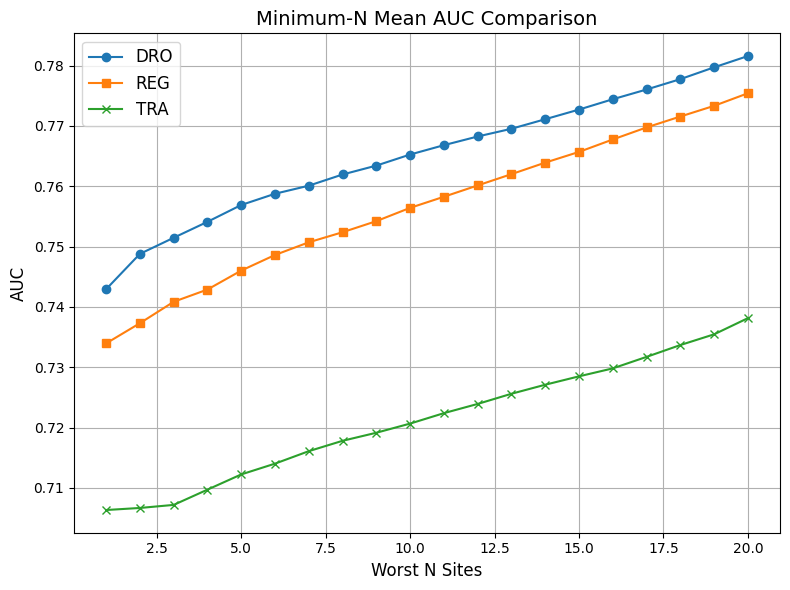

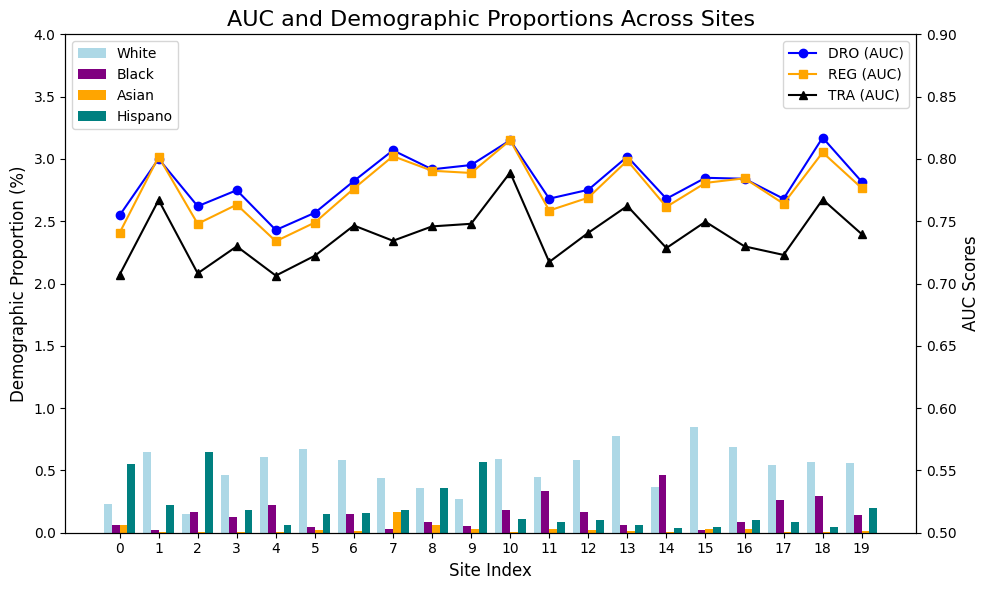

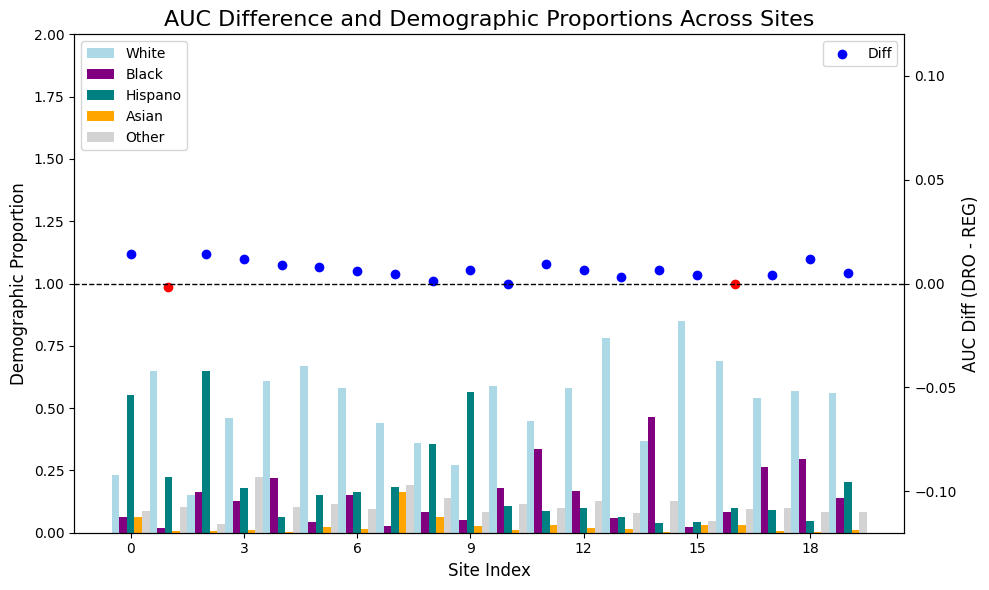


Mean's Comparison Results:
              Comparison    t_stat   p_value
0  Regularization vs DRO -6.041626  0.000008


,Comparison,t_stat,p_value
0,Regularization vs DRO,-6.041626,0.000008


In [4]:
from src.utils_plot import plot_auc_demographic_comparison
trad_auc = trad_results["auc_all"]
reg_auc = reg_results["auc_all"]
dro_auc = dro_results["auc_all"]
x_values = list(range(0, len(dro_auc) ))
bar_width = 0.2
color = ['lightblue', 'purple', 'teal', 'orange', 'lightgray']
plot_auc_demographic_comparison(
    trad_auc,
    reg_auc,
    dro_auc,
    white_proportion,
    black_proportion,
    asian_proportion,
    hispano_proportion,
    other_proportion,
    filtered_list,
)

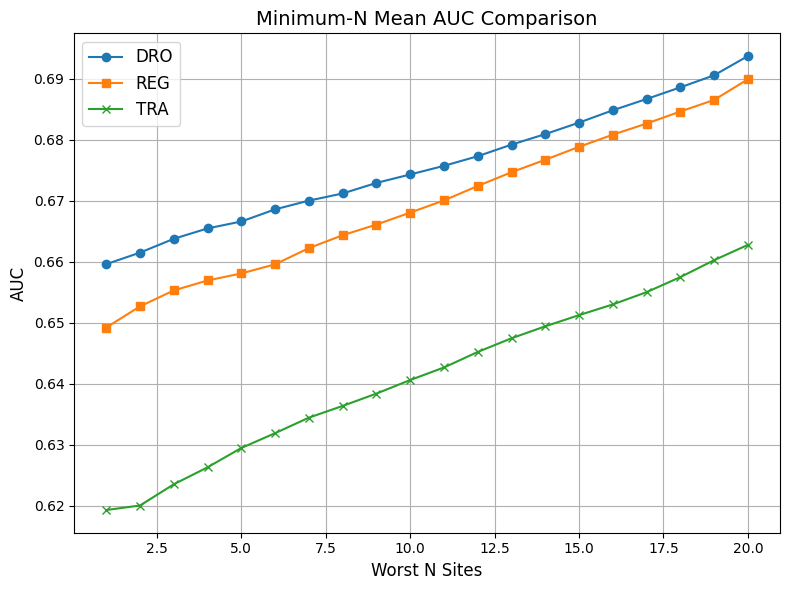

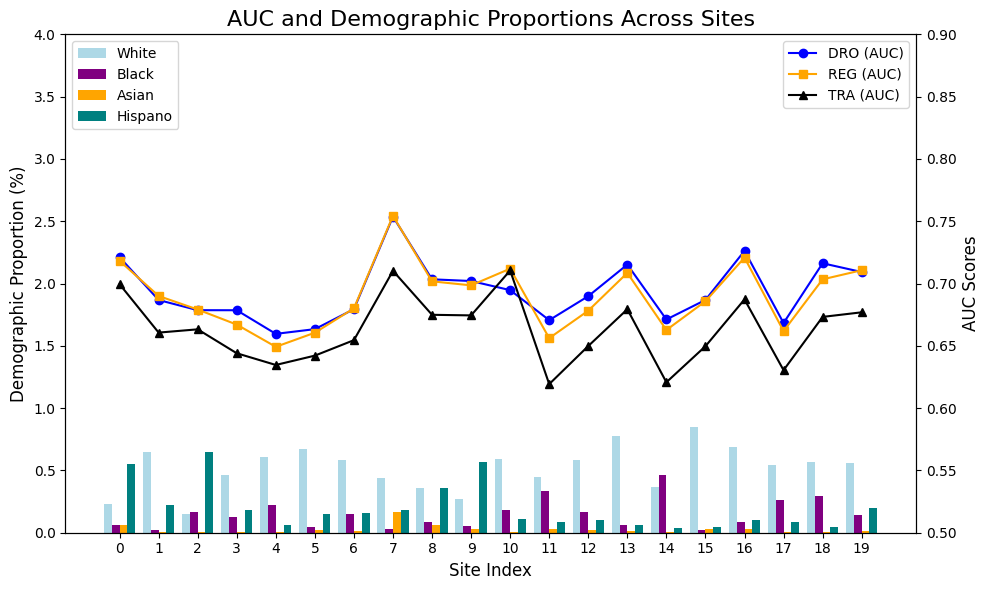

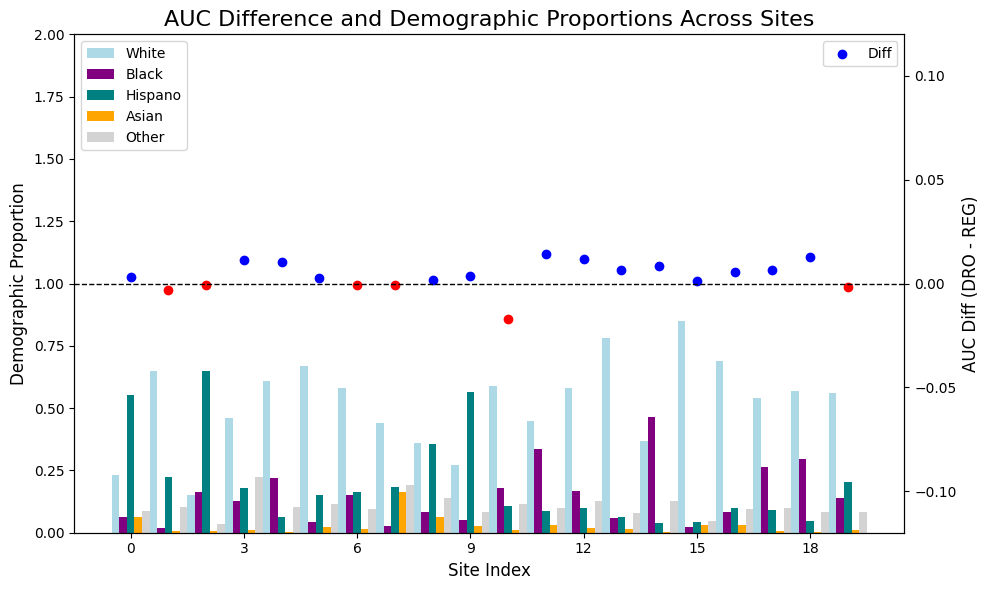


Mean's Comparison Results:
              Comparison   t_stat   p_value
0  Regularization vs DRO -2.35839  0.029221


,Comparison,t_stat,p_value
0,Regularization vs DRO,-2.35839,0.029221


In [5]:
# AUCs on sites excluding y_t == 3
trad_auc_4 = trad_results["auc_exclude_3"]
reg_auc_4 = reg_results["auc_exclude_3"]
dro_auc_4 = dro_results["auc_exclude_3"]

# AUCs on non-white group excluding y_t == 3
reg_white_4 = reg_results["auc_non_white_exclude_3"]
dro_white_4 = dro_results["auc_non_white_exclude_3"]


plot_auc_demographic_comparison(
    trad_auc_4,
    reg_auc_4,
    dro_auc_4,
    white_proportion,
    black_proportion,
    asian_proportion,
    hispano_proportion,
    other_proportion,
    filtered_list,
)


/Users/gaozhiyuan/.pyenv/versions/3.12.1/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:631: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
/Users/gaozhiyuan/.pyenv/versions/3.12.1/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


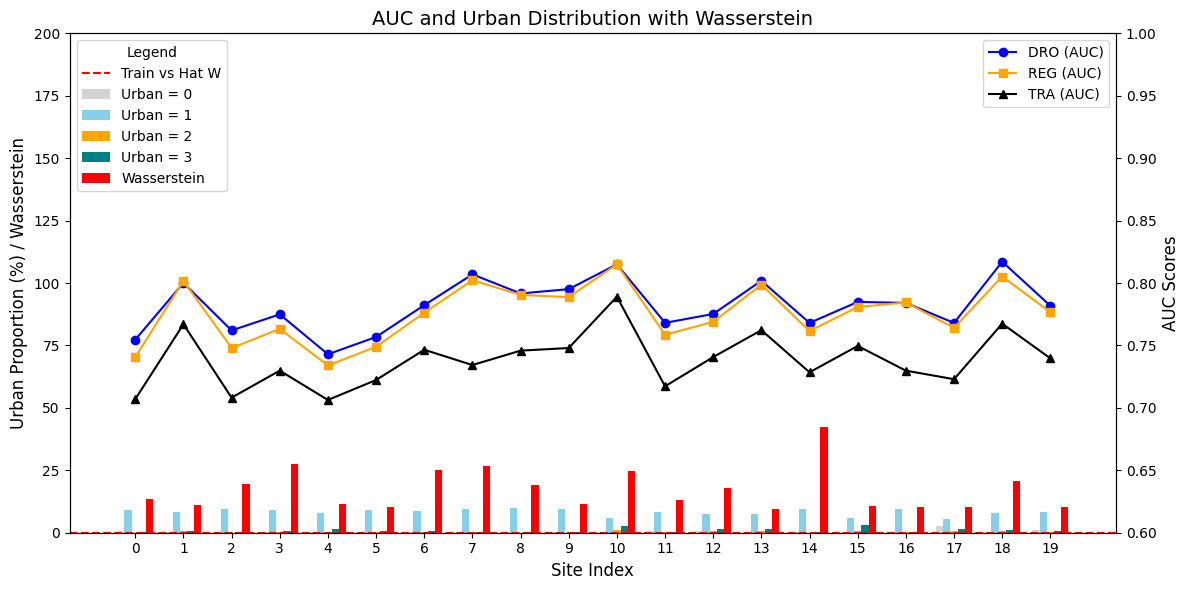

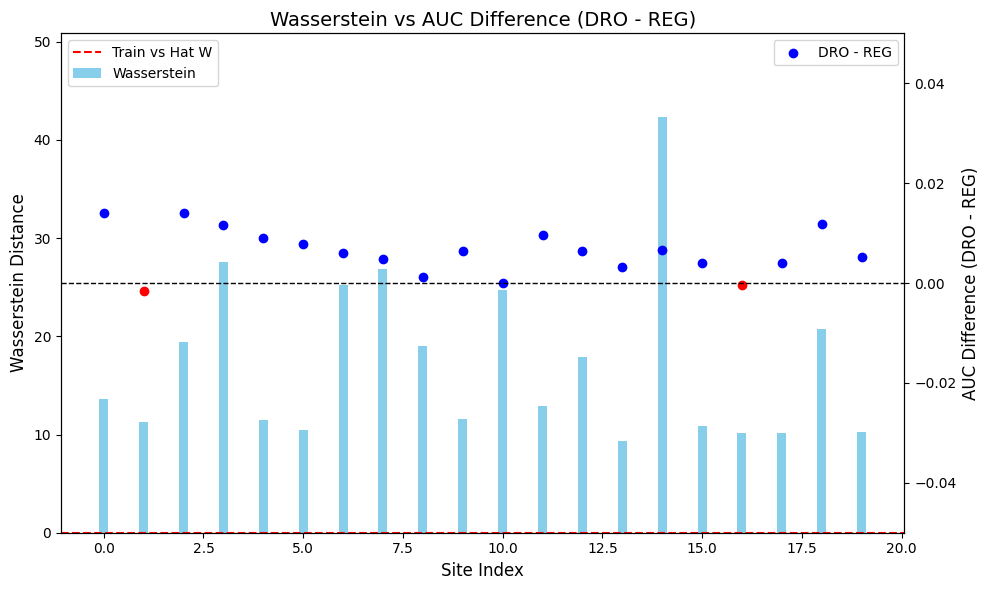


T-test Comparison Results:
                      Comparison     t_stat       p_value
0  Traditional vs Regularization -16.626077  8.887214e-13
1             Traditional vs DRO -18.978754  8.239756e-14
2          Regularization vs DRO  -6.041626  8.220754e-06


In [6]:
from src.utils_plot import plot_wasserstein_and_urban_vs_auc


was_value, auc_diff, ttest_result, was_train_hat = plot_wasserstein_and_urban_vs_auc(
    data_train=data_train,
    y_train=y_train,
    data_mapping=data_mapping,
    hatdata=hatdata,
    filtered_list=filtered_list,
    top_vars=top_vars,
    trad_auc=trad_auc,
    reg_auc=reg_auc,
    dro_auc=dro_auc
)

100%|██████████| 200/200 [00:12<00:00, 16.18it/s]


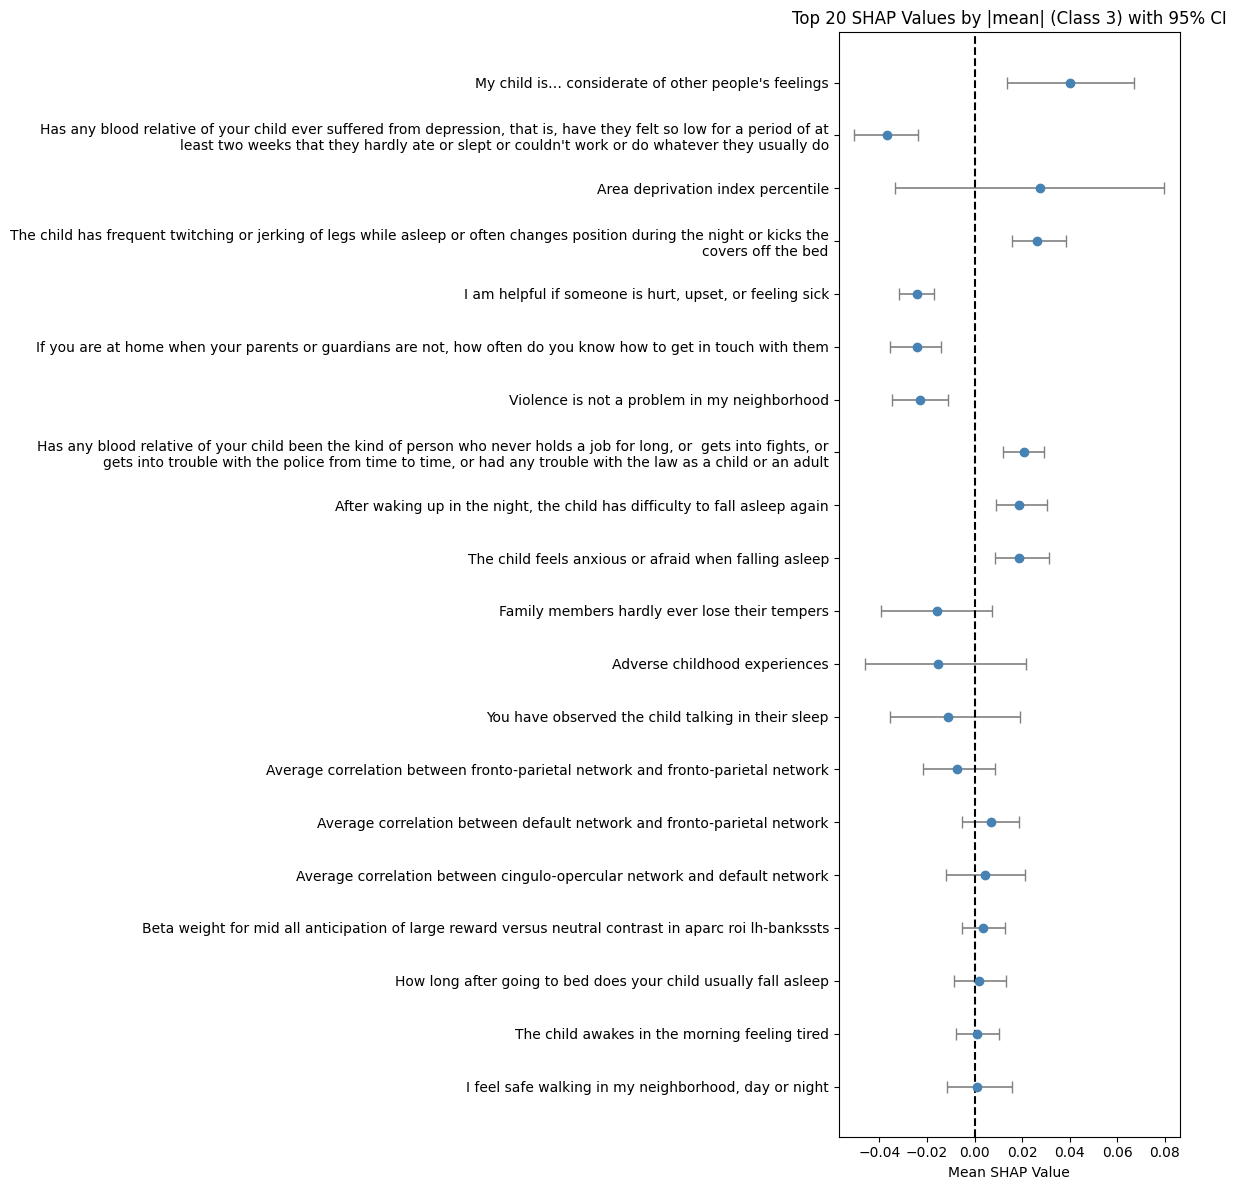

In [45]:
from src.utils_shap import compute_and_plot_shap_kernel_autoquestion

X_np = X_train  
summary = compute_and_plot_shap_kernel_autoquestion(
    trad_model.model,
    X_sample=X_np,
    feature_names=top_vars,
    class_index=3,
    top_n=20,
    csv_path="data/supplementary_table.csv"  
)

100%|██████████| 200/200 [00:12<00:00, 16.01it/s]


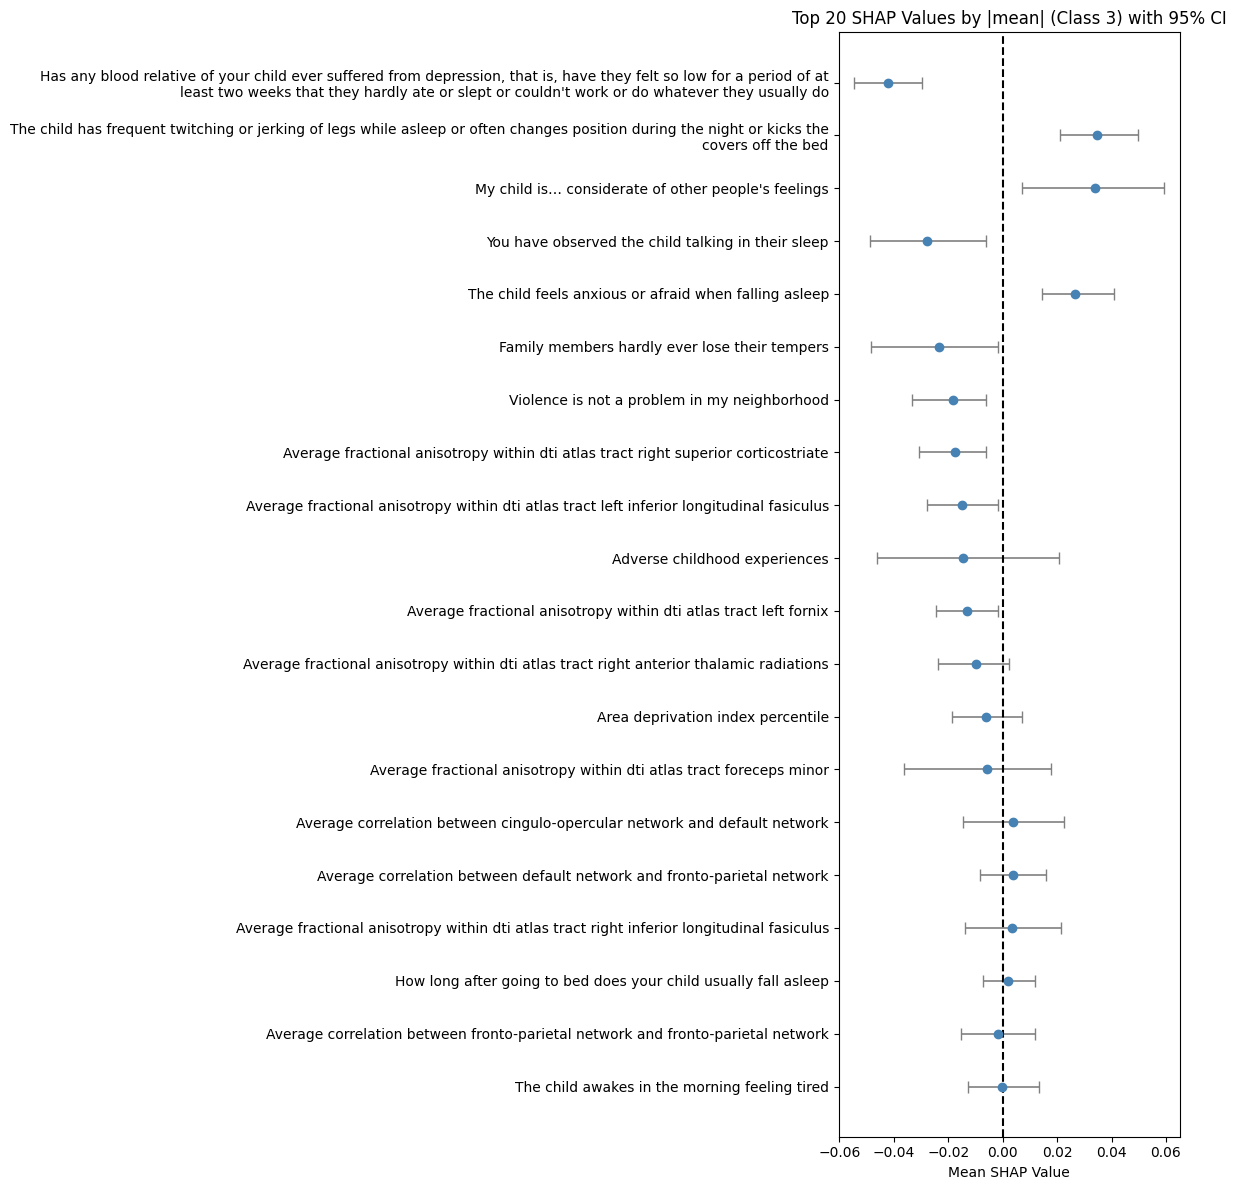

In [37]:
summary = compute_and_plot_shap_kernel_autoquestion(
    reg_model.model,
    X_sample=X_np,
    feature_names=top_vars,
    class_index=3,
    top_n=20,
    csv_path="data/supplementary_table.csv"  
)

100%|██████████| 200/200 [00:12<00:00, 16.14it/s]


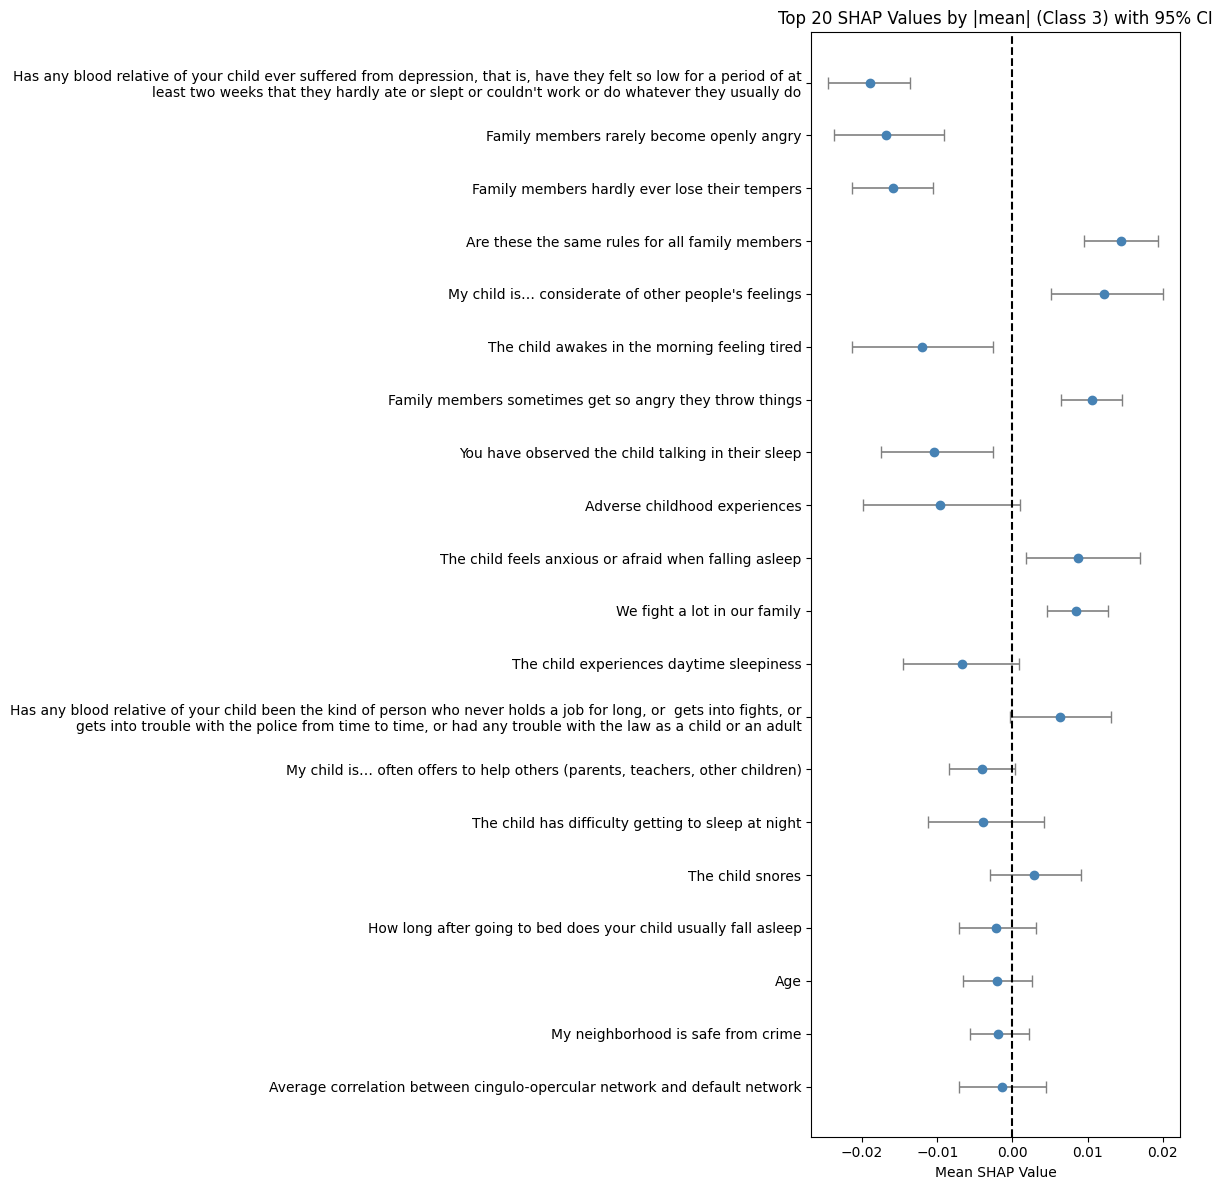

In [39]:
summary = compute_and_plot_shap_kernel_autoquestion(
    dro_model.model,
    X_sample=X_np,
    feature_names=top_vars,
    class_index=3,
    top_n=20,
    csv_path="data/supplementary_table.csv"  
)

In [46]:
X_train

array([[ 1.,  9., 18., ...,  0.,  0.,  0.],
       [ 0.,  9., 18., ...,  0.,  0.,  0.],
       [ 0., 10., 20., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  7., 18., ...,  0.,  0.,  1.],
       [ 1.,  9., 18., ...,  0.,  0.,  0.],
       [ 0.,  7., 18., ...,  0.,  0.,  0.]], shape=(2334, 134))

In [49]:
X_train

array([[ 0.88797846,  0.75654549,  0.12641473, ..., -0.34324349,
        -0.05864624, -0.27760596],
       [-1.12615344,  0.75654549,  0.12641473, ..., -0.34324349,
        -0.05864624, -0.27760596],
       [-1.12615344,  1.32560034,  1.16716246, ..., -0.34324349,
        -0.05864624, -0.27760596],
       ...,
       [-1.12615344, -0.38156419,  0.12641473, ..., -0.34324349,
        -0.05864624,  3.60222819],
       [ 0.88797846,  0.75654549,  0.12641473, ..., -0.34324349,
        -0.05864624, -0.27760596],
       [-1.12615344, -0.38156419,  0.12641473, ..., -0.34324349,
        -0.05864624, -0.27760596]], shape=(2334, 134))